# Similaridade de Produtos
Aqui implemento a biblioteca Word2Vec para encontrar os produtos mais similares na base.

In [73]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from numpy import mean
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import heatmap
from warnings import filterwarnings

import matplotlib.pyplot as plt

In [2]:
filterwarnings('ignore')

## Importando a base
Leiturado do arquivo em csv e transformação em uma lista de listas que é o input de treinamento do modelo.

In [3]:
base = read_csv('dados.csv')

base['value_counts'] = base['description'].str.len()
base = base[base['value_counts'] > 40]

base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8701 entries, 0 to 9998
Data columns (total 18 columns):
uniq_id                                        8701 non-null object
product_name                                   8701 non-null object
manufacturer                                   8699 non-null object
price                                          7452 non-null object
number_available_in_stock                      6565 non-null object
number_of_reviews                              8690 non-null object
number_of_answered_questions                   8048 non-null float64
average_review_rating                          8690 non-null object
amazon_category_and_sub_category               8110 non-null object
customers_who_bought_this_item_also_bought     7853 non-null object
description                                    8701 non-null object
product_information                            8652 non-null object
product_description                            8701 non-null object
items_cu

In [4]:
base_treino = base[['description']].dropna()
base_treino = base_treino['description'].apply(simple_preprocess)
base_treino = list(base_treino)

## Treinando o modelo
Aqui geramos o dicionario e treinamos o modelo para podermos ter a similaridade dos produtos

In [5]:
model = Word2Vec(base_treino)
model.train(base_treino, total_examples=len(base_treino), epochs=10)

(4795960, 6189010)

## Gerando os produtos similares
A partir do modelo treinado sera gerado uma matriz com a similaridade entre os produtosda base.

In [6]:
## Função que a partir de uma frase, faz uma média dos vetores das paralvras dessa frase e gera
## um vetor para a frase.

def sentence_vector(sentence, model):
    words = [word for word in simple_preprocess(sentence) if word in model.wv.vocab]
    
    if len(words) >= 1:
        return mean(model[words], axis=0).reshape(1, -1)
    else:
        return []

In [32]:
## Função que a partir da similaridade dos cossenos, cria uma % de similaridade entre frases

def similarity(sentence1, sentence2, model):
    sv1 = sentence_vector(sentence1, model)
    sv2 = sentence_vector(sentence2, model)
    
    return round(mean((cosine_similarity(sv1, sv2) + 1) / 2) * 100, 2)

In [76]:
## Função que gera uma matriz com a similaridade de todos os produtos por todos os produtos

def matrix_similarity(base, model):
    matrix_similarity = DataFrame()
    for item_1 in base['description']:
        similarity_list = []
        column_name = '_'.join(simple_preprocess(item_1))

        for item_2 in base['description']:
            similarity_list.append(similarity(item_2, item_1, model))

        matrix_similarity[column_name] = Series(similarity_list)
    
    matrix_similarity.set_index(base['description'])
    
    return matrix_similarity

Similaridade dos 25 primeiros produtos

In [77]:
matrix = matrix_similarity(base[['description']].head(25), model)

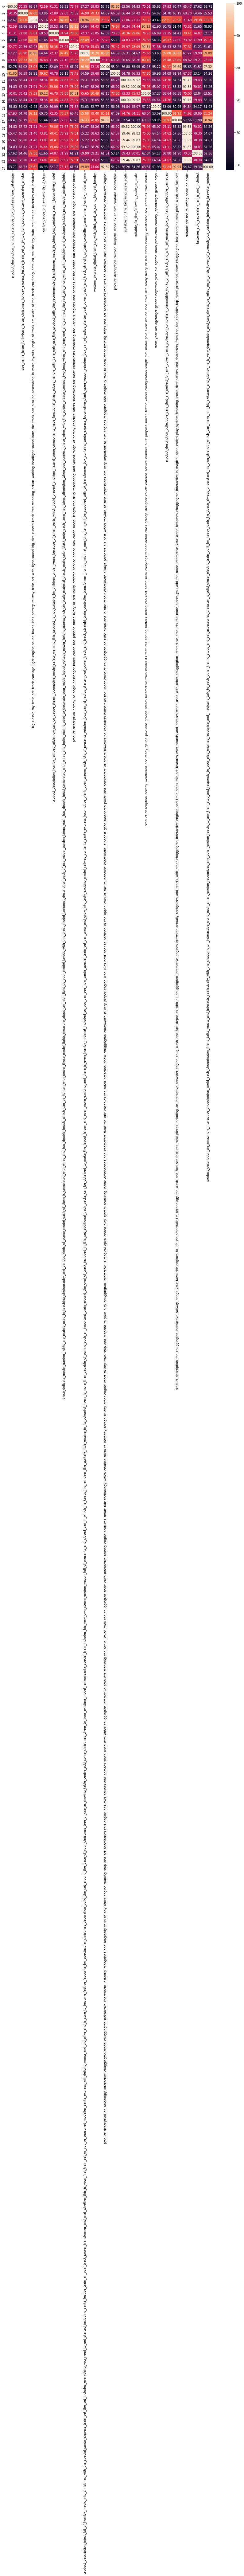

In [79]:
plt.figure(figsize=(15, 10))
heatmap(matrix, annot=True, fmt='.2f')
plt.show()